<a href="https://colab.research.google.com/github/PPierzc/PracowniaEEG/blob/master/Widmowa_analiza_parametryczna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

! rm -rf PracowniaEEG
! git clone https://github.com/PPierzc/PracowniaEEG.git
  
import PracowniaEEG.filters as filters
import PracowniaEEG.cw4_utils as utils
import PracowniaEEG.mtmvar as mtmvar

! pip install wget
import wget

!pip install obci_readmanager
from obci_readmanager.signal_processing.read_manager import ReadManager

import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import scipy


sns.set()
sns.set_context("talk", font_scale=1.4)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Cloning into 'PracowniaEEG'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 185 (delta 14), reused 0 (delta 0), pack-reused 157
Receiving objects: 100% (185/185), 74.76 MiB | 15.71 MiB/s, done.
Resolving deltas: 100% (91/91), done.
  Running setup.py bdist_wheel for wget ... - \ done
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4d

# Zadanie 1

In [0]:
filename = "gdrive/My Drive/pracowniaEEG/cw1/zamkniete"
mgr = ReadManager("%s.xml"%filename, "%s.raw"%filename, "%s.tag"%filename)
fs = int(float(mgr.get_param("sampling_frequency")))
num_of_channels = int(mgr.get_param("number_of_channels"))
channels_names = mgr.get_param("channels_names")

raw_syg_open = mgr.get_microvolt_samples()
t = np.arange(raw_syg_open.shape[1])/fs

choosen_channel = "O2"
s = raw_syg_open[channels_names.index(choosen_channel),:]
del(raw_syg_open)

s = filters.butter_highpass_filter(s, 1, fs, order=5)
s = filters.notch_filter(s, 50, fs)

syg = s[len(s)//2 : len(s)//2 + 1000]
syg = syg.reshape(1, syg.size)

x = np.arange(syg.size)
x = x.reshape(1, x.size)


2019-01-22 12:31:34,039 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


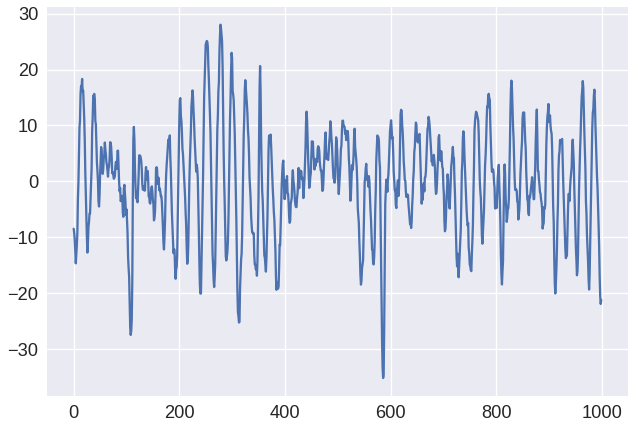

In [0]:
plt.figure()
plt.plot(x[0],syg[0])
plt.show()
plt.close()

In [0]:
AIC = utils.coeffs(s, 1, 5)
for _x in AIC:
  print(len(_x[0]), _x[0])
  
AIC = utils.get_aic_func(syg, 1, 20)
order, params, coefs = utils.best_akaike(syg, 1, 20)

plt.figure()
plt.plot(list(range(1, 21)), AIC)
plt.scatter(order, np.log(np.linalg.det(coefs)) + 2 * order * s.shape[0] * s.shape[0] / s.shape[1], color='r')
plt.show()
plt.close()



#Zadanie 2

In [0]:
def widmo(s, order, f_max, Fs=128):
  efs = np.arange(0, f_max+1, .1)

  k = np.shape(s)[0]
  
  widma = np.empty((efs.size, k, k), dtype="complex")
  
  coef, V = mtmvar.mult_AR(s, order, 1)
  coef *= -1
  
  for j, f in enumerate(efs):
    A = np.eye(k, dtype='complex')
  
    for i in range(len(coef)):
        A += coef[i,:,:] * np.exp(2 * 1j * np.pi * f / Fs)**(-i - 1)

    H = np.linalg.inv(A)
    
    w = np.dot(np.dot(H,V), np.conjugate(H.T))
    
    widma[j] = w
    
  return efs, widma
  
  

In [0]:
xf, S = widmo(syg, order, 128, fs)
plt.figure()
plt.plot(xf, abs(S[:, 0]))
plt.show()
plt.close()


plt.figure()
S = np.fft.rfft(syg)
freq = np.fft.rfftfreq(syg.size, d=1./fs)
plt.plot(freq, abs(S[0,:]))
plt.show()
plt.close()

NameError: ignored

#Zadanie 3

In [0]:
def coherence(widmo, i, j):
  return widmo[:, i, j] / (widmo[:, i, i] * widmo[:, j, j])**.5

def sin(f=32,N=1000,Fs=128,phi=0):
	dt = 1.0/Fs
  
	x = np.arange(0,N/Fs,dt)
	g = np.sin(2*np.pi*f*x + phi)
	return x, g


20


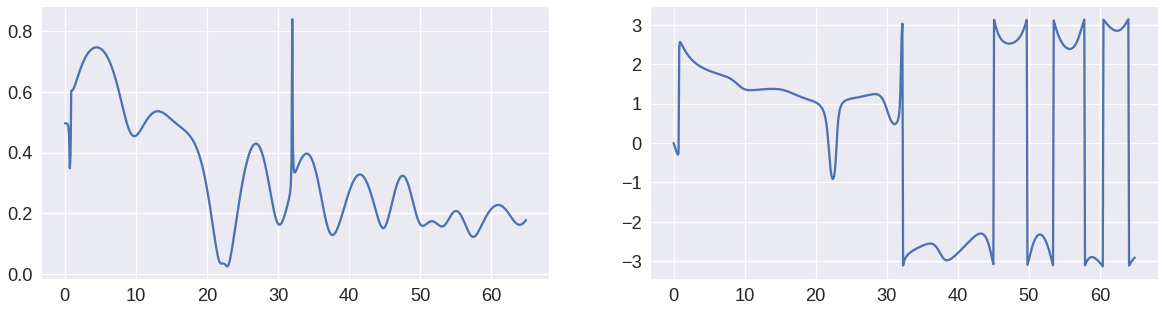

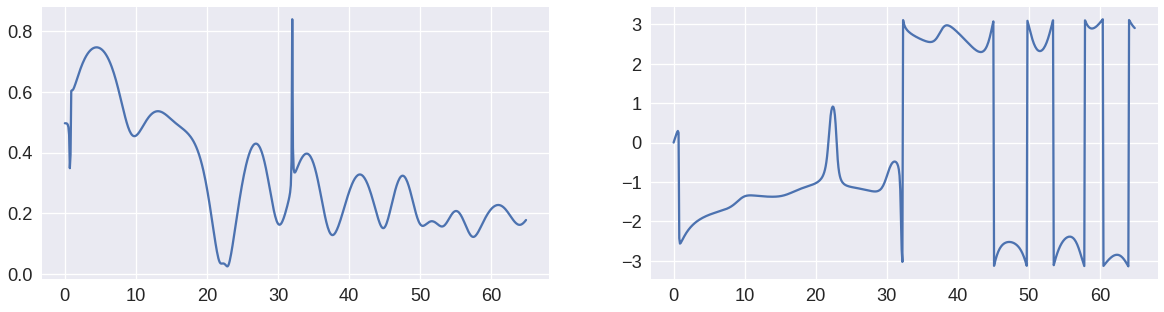

In [0]:

x, g1 = sin()
x, g2 = sin(np.pi/4)

g2 += np.random.random(g2.size) * 0.2

s = np.array([g1,g2])

order, params, coefs = utils.best_akaike(s, 1, 20)
print(order)

efs, widma = widmo(s, order, 128//2, Fs=128)

plt.figure(figsize=(20, 5))
coh = coherence(widma, 0, 1)

plt.subplot(1, 2, 1)
plt.plot(efs, abs(coh))

plt.subplot(1, 2, 2)
plt.plot(efs, np.angle(coh))

plt.show()

plt.figure(figsize=(20, 5))
coh = coherence(widma, 1, 0)
plt.subplot(1, 2, 1)
plt.plot(efs, abs(coh))

plt.subplot(1, 2, 2)
plt.plot(efs, np.angle(coh))

plt.show()

# Zadanie 4

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


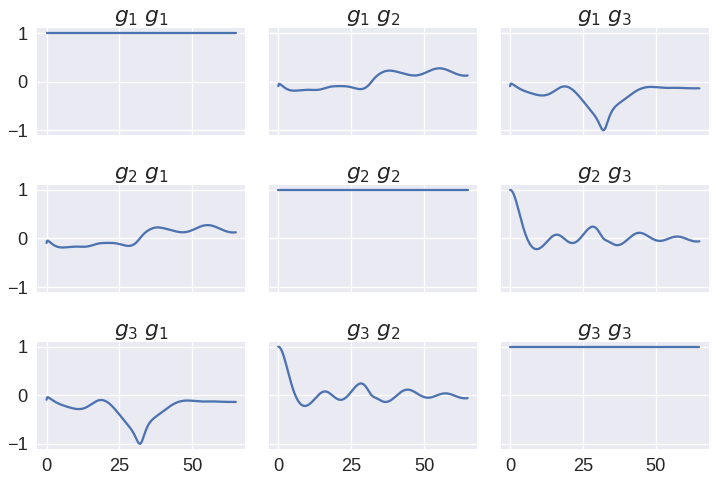

In [0]:
x, g = sin(f=32,N=1002,Fs=128,phi=0)
x, g1 = x[2:], g[2:]
g2 = 0.4 * g[1:-1] + np.random.random(g1.size) * 0.2
g3 = 0.3 * g[0:-2] + np.random.random(g1.size) * 0.2


s = np.array([g1,g2,g3])

order, params, coefs = utils.best_akaike(s, 1, 20)
efs, widma = widmo(s, order, 128//2, Fs=128)


fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True,sharey=True)

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        coh = coherence(widma, i, j)
        col.plot(efs, coh)
        col.set_title('$g_%s$ $g_%s$'%(i+1,j+1))
    
fig.tight_layout()
fig.show()

# Zadanie 5
